##  BDD100k Dataset

- A Diverse Driving Dataset for heterogenous Multi Task learning
- It has labeled annotations for 1000 hours videos, 10 tasks like Object Detection, Semantic Segmentation, Panoptic Segmentation, Instance Segmentation, Drivable Area estimation etc

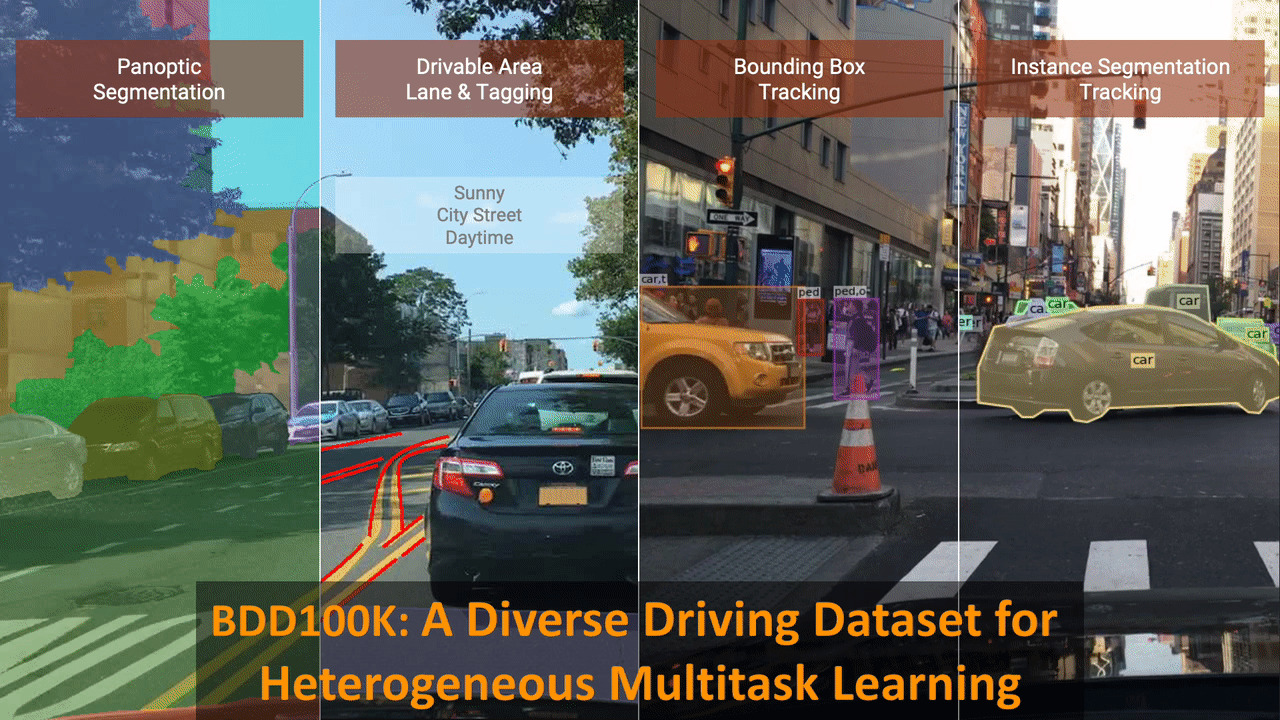

# Basic Imports

In [2]:
# basic imports
import os
import numpy as np
import matplotlib.pyplot as plt

# DL library imports
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

D:\surya\miniconda37\envs\imgseg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load image and labels

In [3]:
targetWidth = 320
targetHeight = 180
dataset_path = os.path.join('../data/')
images = np.load(f'{dataset_path}/image_{targetHeight}_{targetWidth}.npy')
labels = np.load(f'{dataset_path}/label_{targetHeight}_{targetWidth}.npy')
print(f"RGB images shape = {images.shape}, Label images shape = {labels.shape}")

RGB images shape = (3430, 180, 320, 3), Label images shape = (3430, 180, 320)


## Create Torch Dataset class

In [4]:
class BDD100k_dataset(Dataset):
    def __init__(self, images, labels, tf=None):
        """Dataset class for BDD100k_dataset drivable / segmentation data """
        self.images = images
        self.labels = labels
        self.tf = tf
    
    def __len__(self):
        return self.images.shape[0]
  
    def __getitem__(self, index):
        # read source image and convert to RGB, apply transform
        rgb_image = self.images[index]
        if self.tf is not None:
            rgb_image = self.tf(rgb_image)

        # read label image and convert to torch tensor
        label_image  = torch.from_numpy(self.labels[index]).long()
        return rgb_image, label_image  

In [5]:
# Convert to torch tensor and normalize images using Imagenet values
preprocess = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
                ])

data = BDD100k_dataset(images, labels, tf=preprocess)

Splitting Training data into train and validation sets, creating Dataloaders

In [6]:
# split train data into train, validation and test sets
total_count = len(data)
train_count = int(0.7 * total_count) 
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count
train_set, val_set, test_set = torch.utils.data.random_split(data, 
            (train_count, valid_count, test_count), generator=torch.Generator().manual_seed(1))

train_dataloader = DataLoader(train_set, batch_size=8,drop_last=True)
val_dataloader   = DataLoader(val_set, batch_size=8)
test_dataloader  = DataLoader(test_set, batch_size=8)

Let's verify size of images from the dataset

In [7]:
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


## Show Sample images from dataset

In [8]:
# reference : https://github.com/bdd100k/bdd100k/blob/master/bdd100k/label/label.py
from collections import namedtuple
Label = namedtuple( "Label", [ "name", "train_id", "color"])
drivables = [ 
             Label("direct", 0, (219, 94, 86)),        # red
             Label("alternative", 1, (86, 211, 219)),  # cyan
             Label("background", 2, (0, 0, 0)),        # black          
            ]
train_id_to_color = [c.color for c in drivables if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color = np.array(train_id_to_color)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


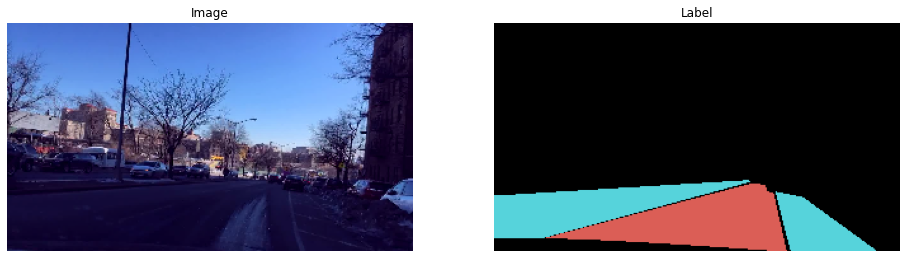

In [11]:
# when using torch datasets we defined earlier, the output image
# is normalized. So we're defining an inverse transformation to 
# transform to normal RGB format
inverse_transform = transforms.Compose([
        transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
    ])

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(16,6))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');


### References
- [BDD100k arXiv paper](https://arxiv.org/abs/1805.04687)
- [BDD100k website](https://bdd-data.berkeley.edu/)
- [BDD100k github homepage](https://github.com/bdd100k/bdd100k)
- [BDD100k documentation](https://doc.bdd100k.com/format.html)